In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

from glob import glob
from os.path import join
from scipy import interpolate

import itertools
import datetime
import time
import sys  

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [4]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'

PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2
ALTITUDE = 3

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
#     tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi


/bin/bash: nvidia-smi: command not found


# Evaluation Functions

In [2]:
def plot_altitude_rmse(nnet, X, T, NWP_Temp):
    """
    Plot the RMSE over different altitudes for some NeuralNetwork architecture.

    :params
    ---
    nnet : class
        Trained Neural Network class that will be used for evaluation
    X : np.array
        Input to the trained nnet
    T : np.array
        Targets to compare to for the nnet. Will often be the temperature profile from the RAOB.
    NWP_Temp : np.array
        Temperature profile from the NWP mode. Should have the same shape T.
    """
    def plot_rmse(rmse, mean_rmse, color, label):
            axs[0].plot(alt, rmse, color=color)
            axs[0].hlines(mean_rmse, alt[0], alt[-1], label=f'{label} {mean_rmse:.3f}',
                          color=color, linestyle='--')

            axs[1].plot(alt[:surface_error], rmse[:surface_error], color=color)
            axs[1].hlines(mean_rmse, alt[:surface_error][0], alt[:surface_error][-1],
                          color=color, linestyle='--')
            
    alt = raob[0, :, ALTITUDE]
    surface_error = 100
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs = axs.ravel()
    
    Y = nnet.use(X)
    ml_rmse = np.sqrt((np.mean((Y - T)**2, axis=0)))
    ml_mean_rmse = ml.rmse(Y, T)
    plot_rmse(ml_rmse, ml_mean_rmse, 'k', 'ML')

    rap_rmse = np.sqrt((np.mean((NWP_Temp - T)**2, axis=0)))
    rap_mean_rmse = ml.rmse(NWP_Temp, T)
    plot_rmse(rap_rmse, rap_mean_rmse, 'r', 'RAP')

    axs[0].set_xlabel('Altitude (m)')
    axs[1].set_xlabel('Altitude (m)')
    axs[0].set_ylabel('RMSE (C)')
    axs[0].legend();
    
    
def plot_loss(nnet):
    fig, ax = plt.subplots(1, figsize=(8, 4))

    ax.plot(nnet.history['loss'], label='train')
    ax.plot(nnet.history['val_loss'], label='val')
    ax.legend();

# RAP

## Data Loader

In [4]:
xar = xr.open_dataset(sorted(glob(join(processed_vol, '*')))[0])
xar

<xarray.Dataset>
Dimensions:         (band: 8, goes_x: 28, goes_y: 28, nwp_dims: 50, profile_dims: 2048, rtma_type: 3, rtma_x: 28, rtma_y: 28)
Coordinates:
  * goes_y          (goes_y) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * goes_x          (goes_x) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * band            (band) int64 8 9 10 11 13 14 15 16
  * rtma_y          (rtma_y) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * rtma_x          (rtma_x) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * rtma_type       (rtma_type) object 'LPI' 'LRI' 'LTI'
  * profile_dims    (profile_dims) int64 0 1 2 3 4 ... 2043 2044 2045 2046 2047
  * nwp_dims        (nwp_dims) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    sonde_rel_time  datetime64[ns] ...
    sonde_file      object ...
    sonde_pres      (profile_dims) float64 ...
    sonde_tdry      (profile_dims) float64 ...
    sonde_dp        (profile_dims) float64 ...
    sonde_alt       (profile_dims) float64 ...
    nwp_file        object ...
    nwp_lon         object ...
    nwp_lat         object ...
    nwp_pres        (nwp_dims) float64 ...
    nwp_tdry        (nwp_dims) float64 ...
    nwp_spfm        (nwp_dims) float64 ...
    nwp_alt         (nwp_dims) float64 ...
    goes_files      (band) object ...
    goes_abi        (band, goes_y, goes_x) float32 ...
    goes_lon        (goes_y, goes_x) float64 ...
    goes_lat        (goes_y, goes_x) float64 ...
    rtma_files      (rtma_type) object ...
    rtma_values     (rtma_type, rtma_y, rtma_x) float32 ...
    rtma_lon        (rtma_y, rtma_x) float64 ...
    rtma_lat        (rtma_y, rtma_x) float64 ...

In [5]:
# TODO: Should this be done in preprocessing?

def interpolate_to_height_intervals(alt, y, altitude_intervals):
    f = interpolate.interp1d(alt, y)
    return f(altitude_intervals)


def load_samples():
    files = sorted(glob(join(processed_vol, '*')))
    print(f'total of {len(files)} samples!')
    
    fp = FloatProgress(min=0, max=(len(files)))
    display(fp)

    raob = []
    rap = []
    goes = []
    rtma = []
    
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        raob_profile = np.concatenate((xar.sonde_pres.values.reshape(-1,1),
                                       xar.sonde_tdry.values.reshape(-1,1),
                                       xar.sonde_dp.values.reshape(-1,1),
                                       xar.sonde_alt.values.reshape(-1,1)), axis=1)
        raob.append(raob_profile)
        
        alt = xar.nwp_alt.values
        altitude_intervals = np.linspace(alt[0], 18_000, 2048)
        
        pres = interpolate_to_height_intervals(alt, xar.nwp_pres.values/100., altitude_intervals)
        tdry = interpolate_to_height_intervals(alt, xar.nwp_tdry.values-272.15, altitude_intervals)
        spfm = interpolate_to_height_intervals(alt, xar.nwp_spfm.values, altitude_intervals)
        
        rap_profile = np.concatenate((pres.reshape(-1,1),
                                      tdry.reshape(-1,1),
                                      spfm.reshape(-1,1),
                                      altitude_intervals.reshape(-1,1)), axis=1)
        rap.append(rap_profile)
        goes.append(xar.goes_abi.values)
        rtma.append(xar.rtma_values.values)
        
        xar.close()
        fp.value += 1

    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/len(files):.3f} seconds')
    
    return (np.array(raob), np.array(rap), np.array(goes).transpose(0, 2, 3, 1),
            np.array(rtma).transpose(0, 2, 3, 1))

raob, rap, goes, rtma = load_samples()
raob = raob[:, ::8, :]
rap = rap[:, ::8, :]
print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 142 samples!


FloatProgress(value=0.0, max=142.0)

time: 3.754, avg: 0.026 seconds
(142, 256, 4) (142, 256, 4) (142, 28, 28, 8) (142, 28, 28, 3)


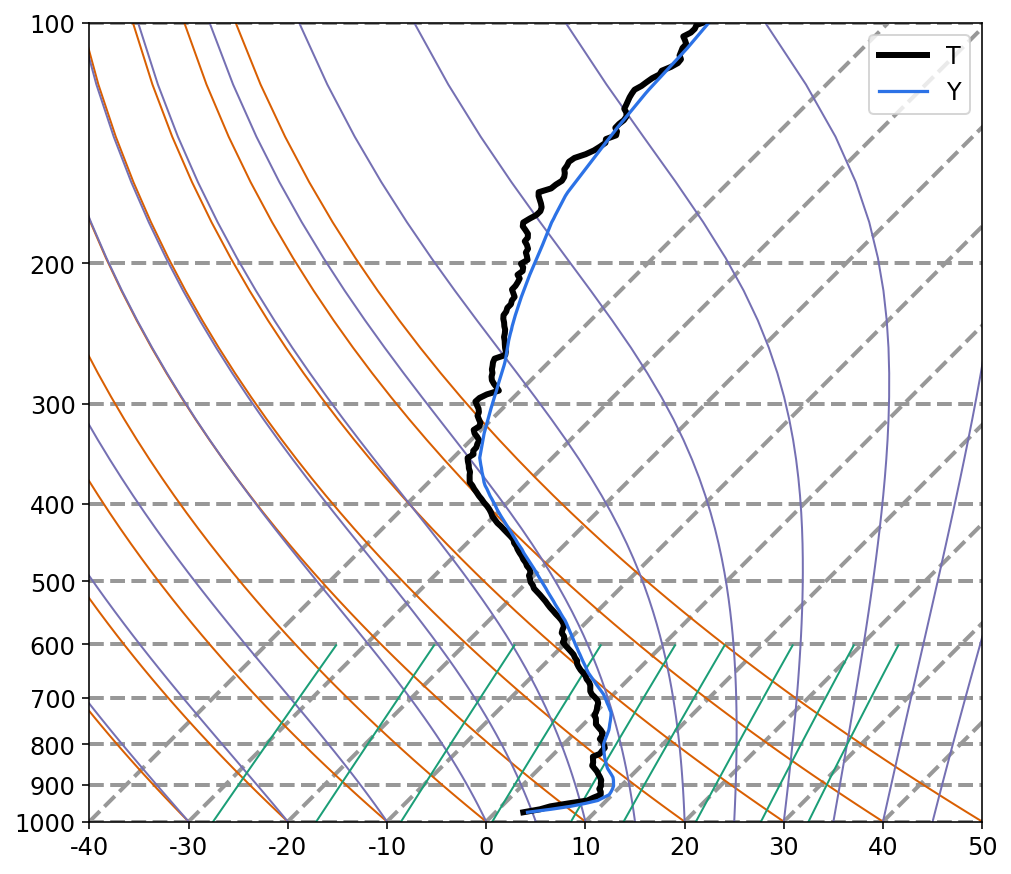

In [157]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = raob[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = rap[i,:,TEMPERATURE]

radiosonde_plotting.plot_predicted_sounding(sounding);

## Linear NN

In [6]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((114, 512), (114, 256), (28, 512), (28, 256))

In [7]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

nnet.model.summary()

nnet.train(Xt, Tt, 25, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________
epoch: 0, loss: 1.54375
epoch: 5, loss: 0.23453
epoch: 10, loss: 0.12728
epoch: 15, loss: 0.09451
epoch: 20, loss: 0.08114
epoch: 24, loss: 0.07479
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.07479 in 1.0713 seconds.

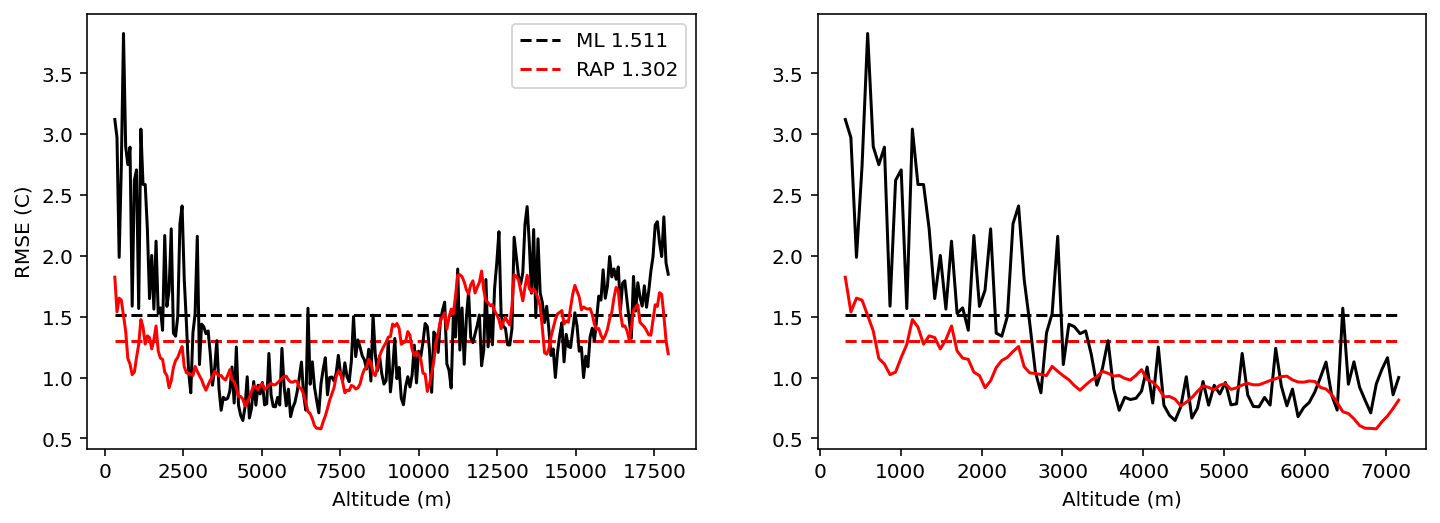

In [7]:
plot_altitude_rmse(nnet, Xe, Te, Xtest[:,:,TEMPERATURE])

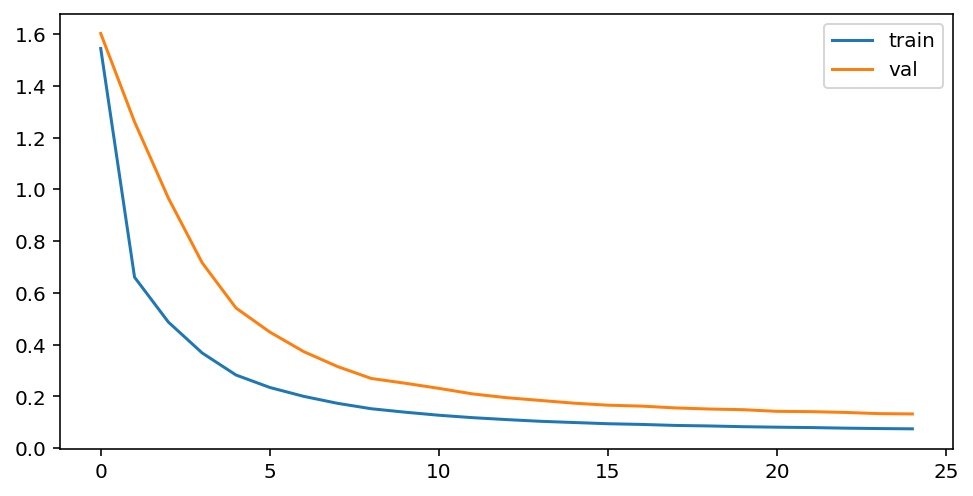

In [8]:
plot_loss(nnet)

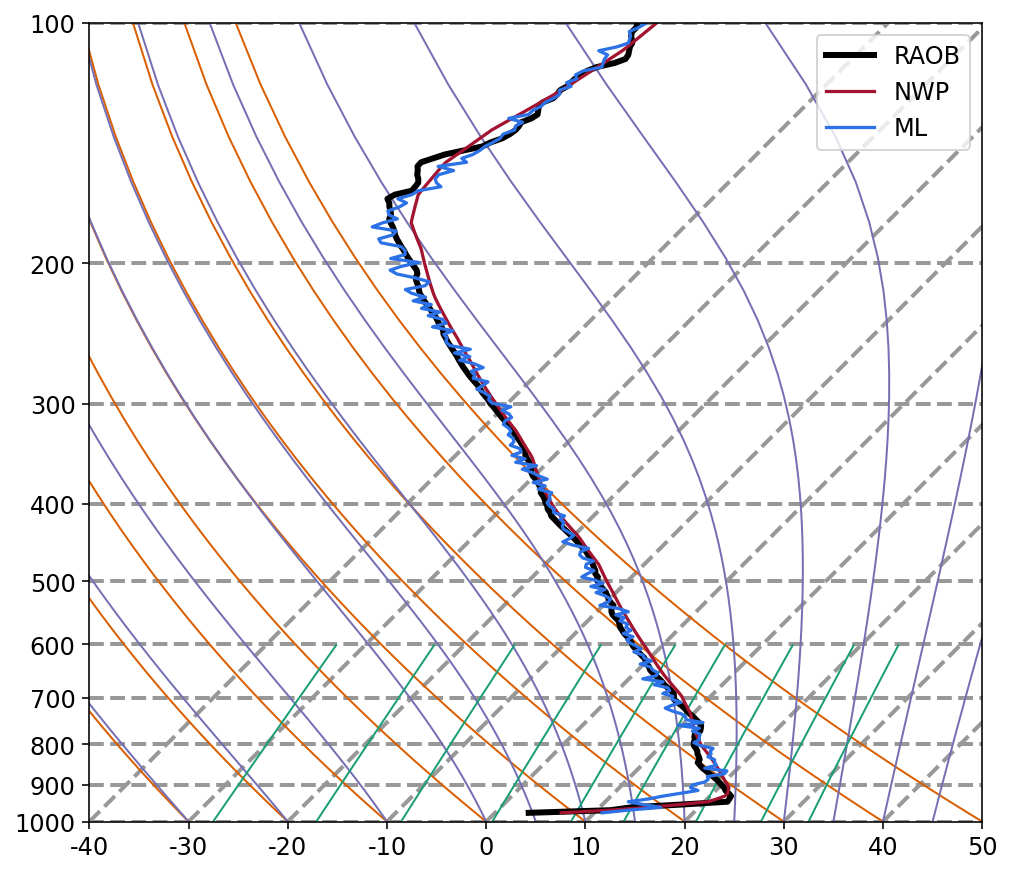

In [9]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Fully Connected NN

In [10]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((114, 512), (114, 256), (28, 512), (28, 256))

In [12]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[nu] * nl for nu in [4, 8, 16, 32, 64] for nl in range(1, 5)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.NeuralNetwork(Xt.shape[1], layer, Tt.shape[1], activation='tanh', seed=1234)

    nnet.train(Xt, Tt, 50, 16, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xt)
    train_percentage.append(ml.rmse(Tt, Y))

    Y = nnet.use(Xe)
    temp = ml.rmse(Te, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=20.0)

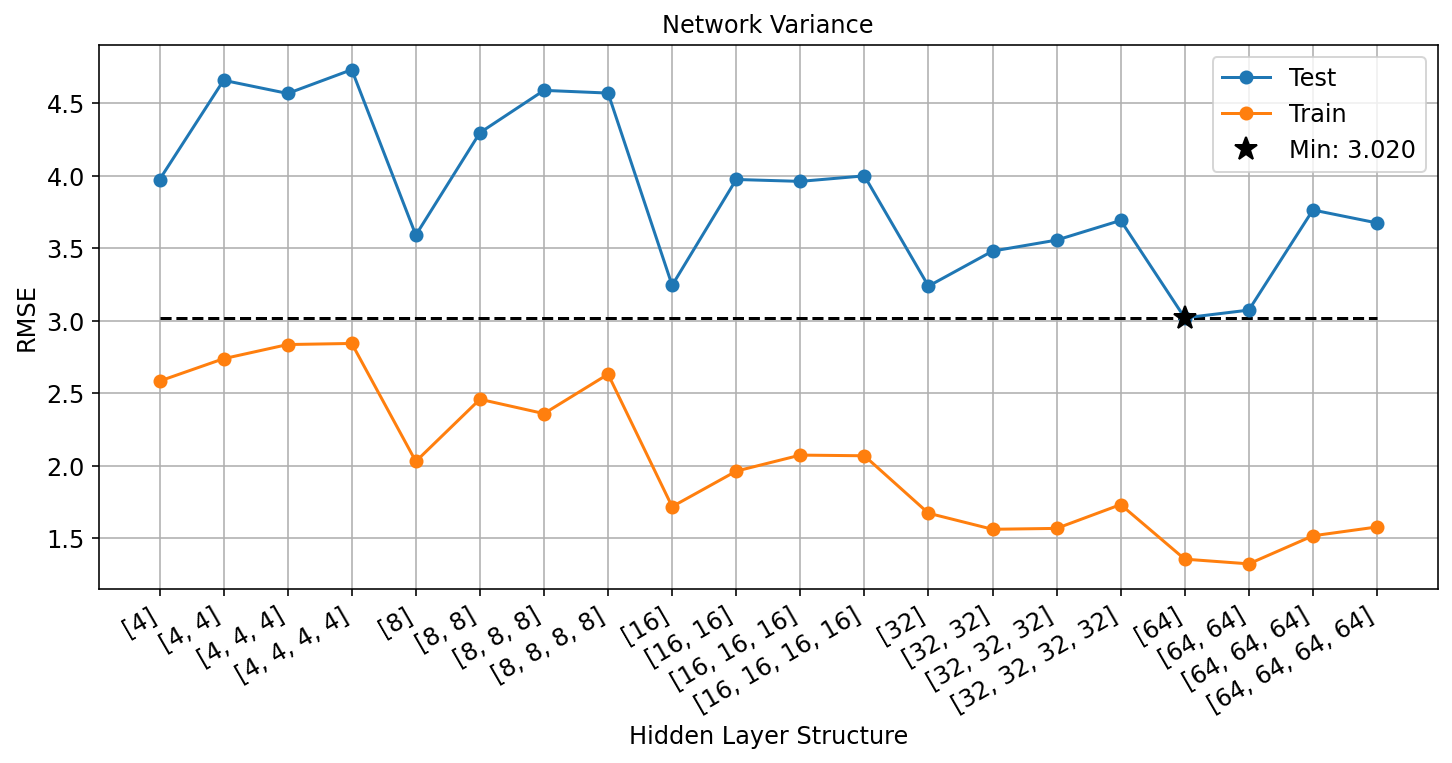

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

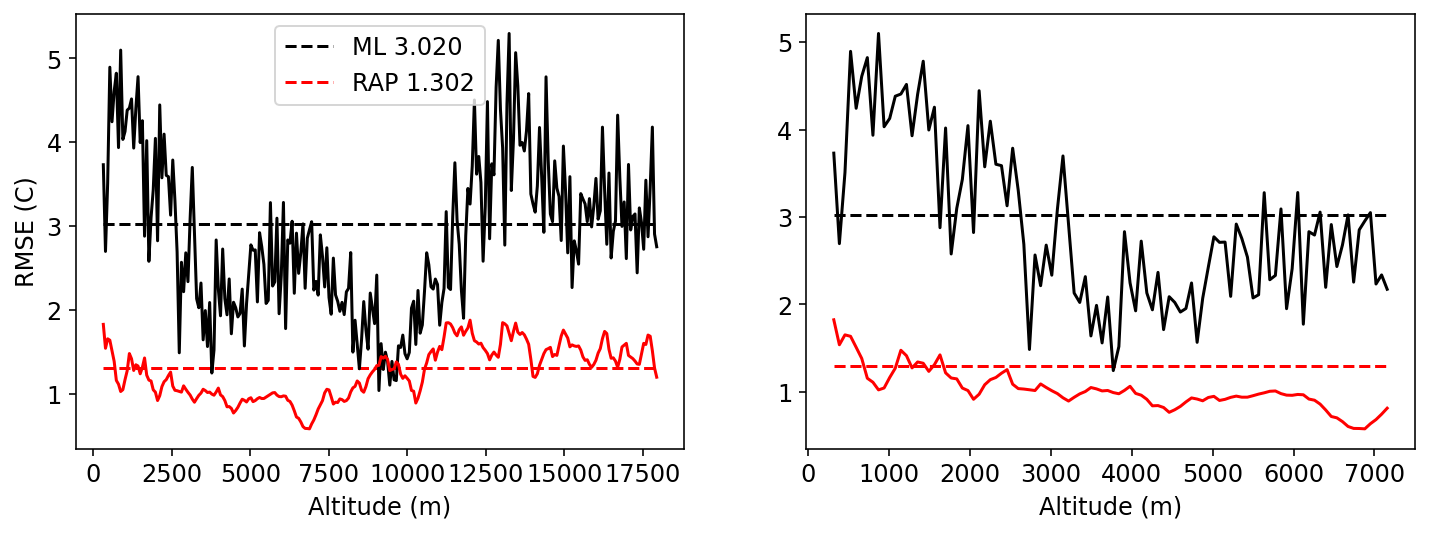

In [15]:
plot_altitude_rmse(best_nnet, Xe, Te, Xtest[:,:,TEMPERATURE])

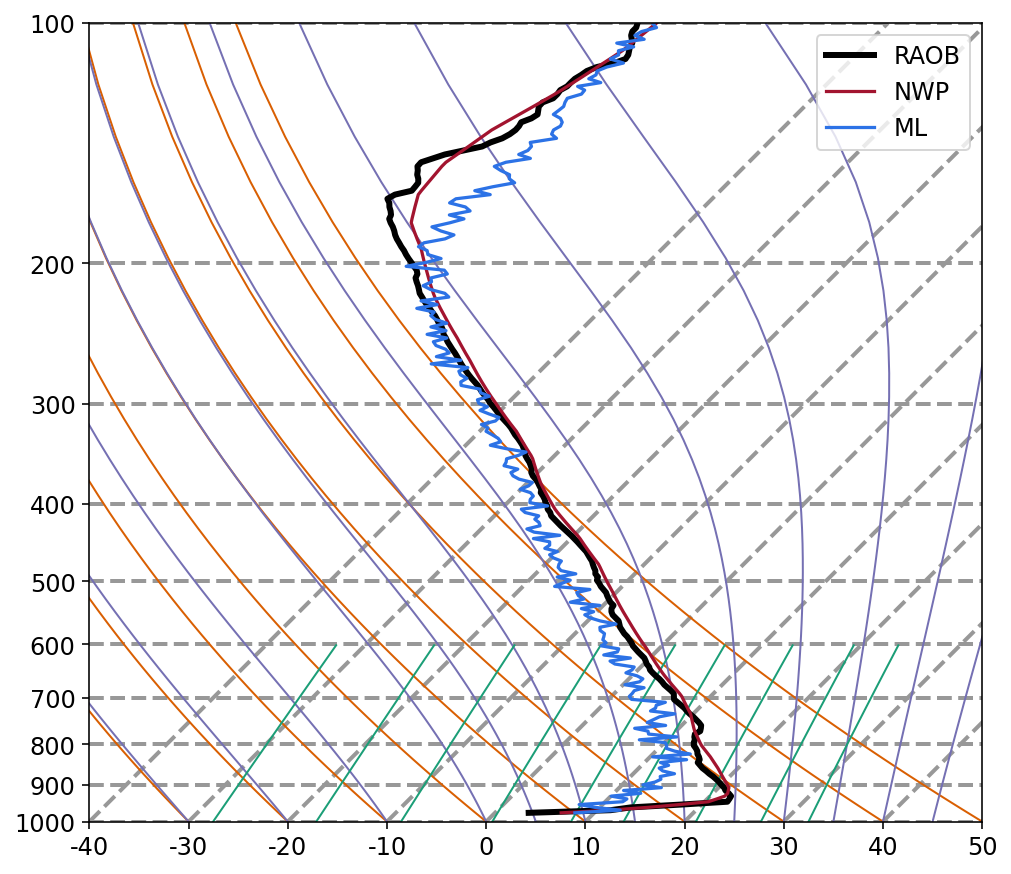

In [16]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Conv1D NN

In [25]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(raob, rap, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((114, 256, 2), (114, 256), (28, 256, 2), (28, 256))

In [50]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], layer, [(10, 1)]*len(layer),
                                         Ttrain.shape[1], activation='tanh', seed=1234)
    nnet.train(Xtrain, Ttrain, 25, 32, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(ml.rmse(Ttrain, Y))

    Y = nnet.use(Xtest)
    temp = ml.rmse(Ttest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=15.0)

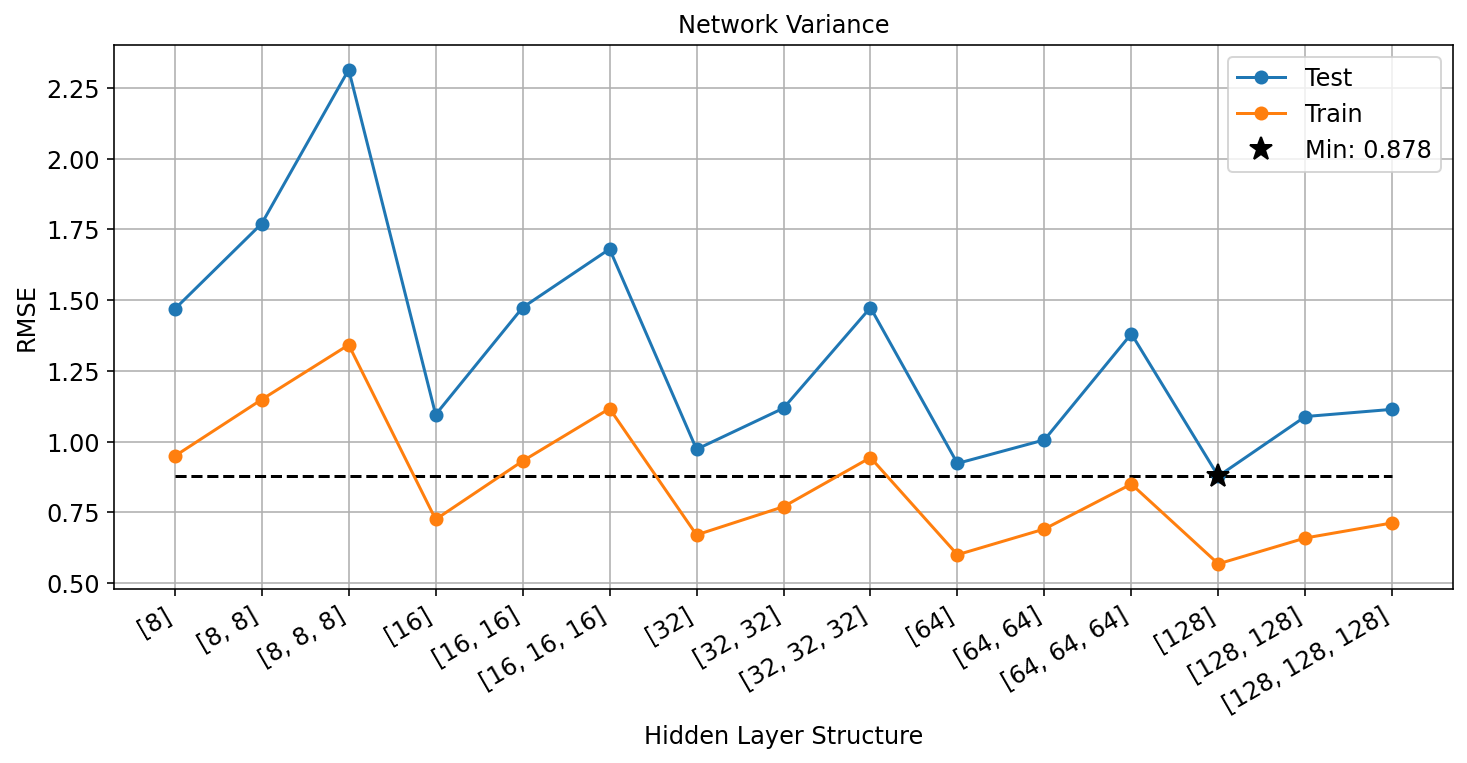

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

In [52]:
best_nnet.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 128)          2688      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4194560   
Total params: 4,197,248
Trainable params: 4,197,248
Non-trainable params: 0
____________________________________________

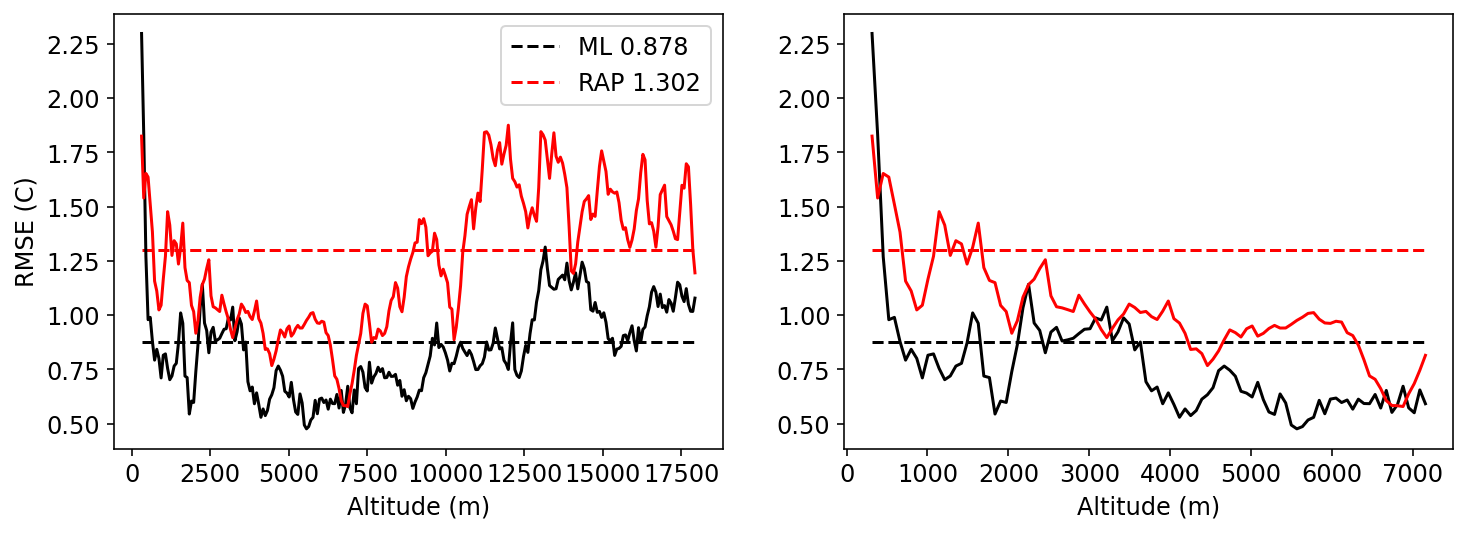

In [53]:
plot_altitude_rmse(best_nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE])

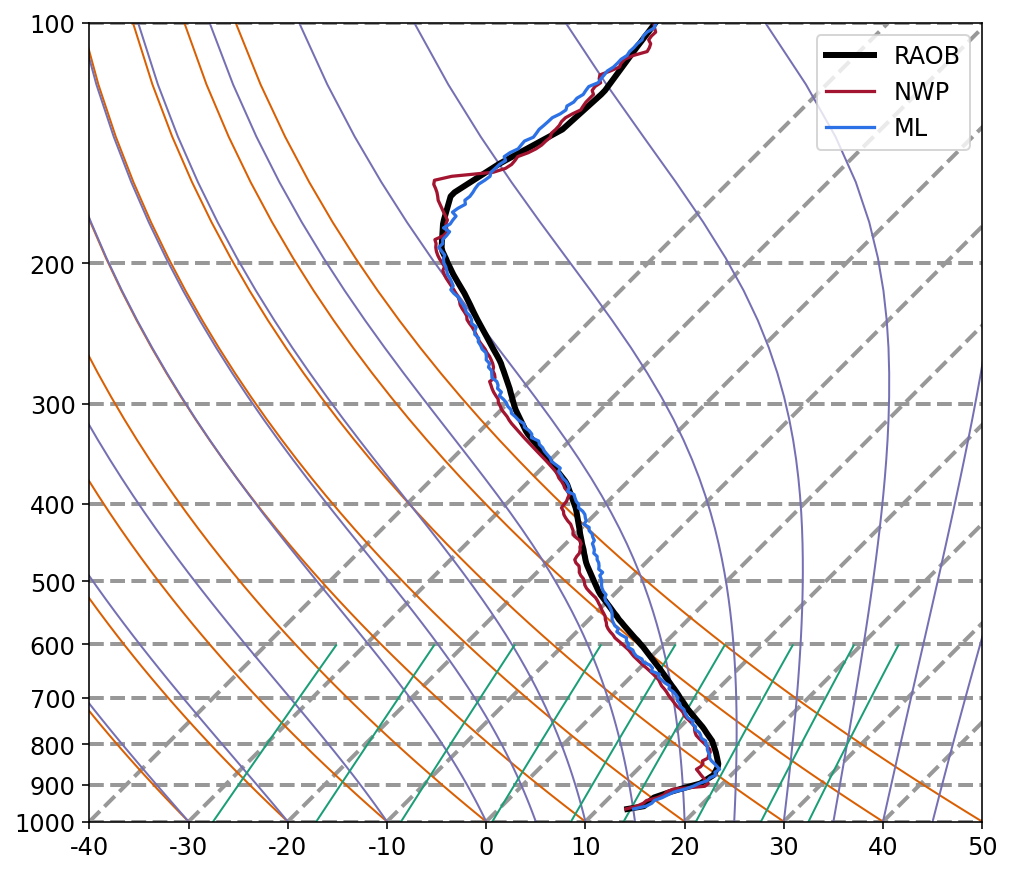

In [54]:
i = 5
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Weighted Loss

In [241]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

In [242]:
def weighted_mean_squared_error(y_true, y_pred, scale, lmda):
    """exponential decay weighted MSE"""
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.squared_difference(y_pred, y_true)

    x = np.arange(diff.shape[1])
    y = lambda x: scale * np.exp(-lmda * x) + 1
    diff *= y(x)

    return K.mean(diff, axis=-1)

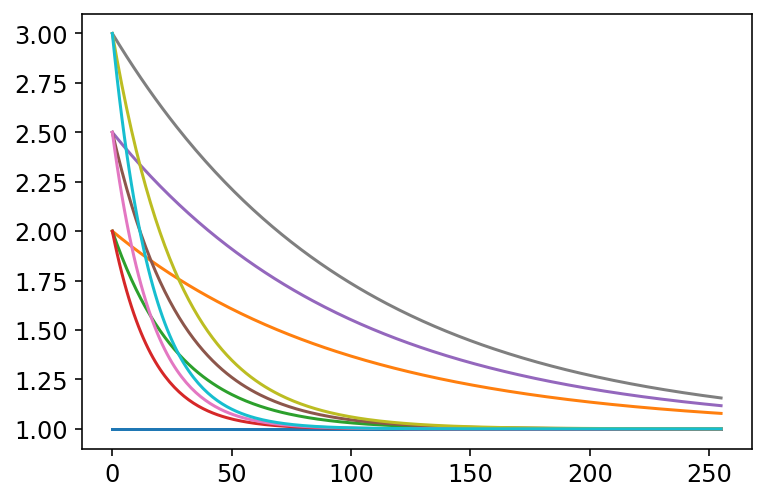

In [275]:
x = np.arange(Xtest.shape[1])

scales = np.linspace(1, 2, 3)
lmdas = np.linspace(0.01, 0.06, 3)

product = list(itertools.product(scales, lmdas))
product.insert(0, (0., 0.))

for scale, lmda in product:
    y = lambda x: scale * np.exp(-lmda * x) + 1
    plt.plot(y(x));

In [289]:
loss_l = []
rmse_l = []
total_rmse_l = []

f = FloatProgress(min=0, max=(len(product)))
display(f)

for scale, lmda in product:
    nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [128], [(10, 1)]*len(layer),
                                             Ttrain.shape[1], activation='tanh', seed=1234)
    
    nnet.train(Xtrain, Ttrain, 20, 32, method='adam', verbose=False, learning_rate=0.001,
               validation=[Xtest, Ttest], loss_f=[lambda y_true,y_pred: 
                                                  weighted_mean_squared_error(y_true, y_pred, 
                                                                              scale=scale, lmda=lmda)])
    
    loss_l.append(nnet.history['val_loss'])
    
    Y = nnet.use(Xtest)
    rmse_l.append(np.sqrt((np.mean((Y - Ttest)**2, axis=0))))
    total_rmse_l.append(ml.rmse(Y, Ttest))
    
    f.value += 1

FloatProgress(value=0.0, max=10.0)

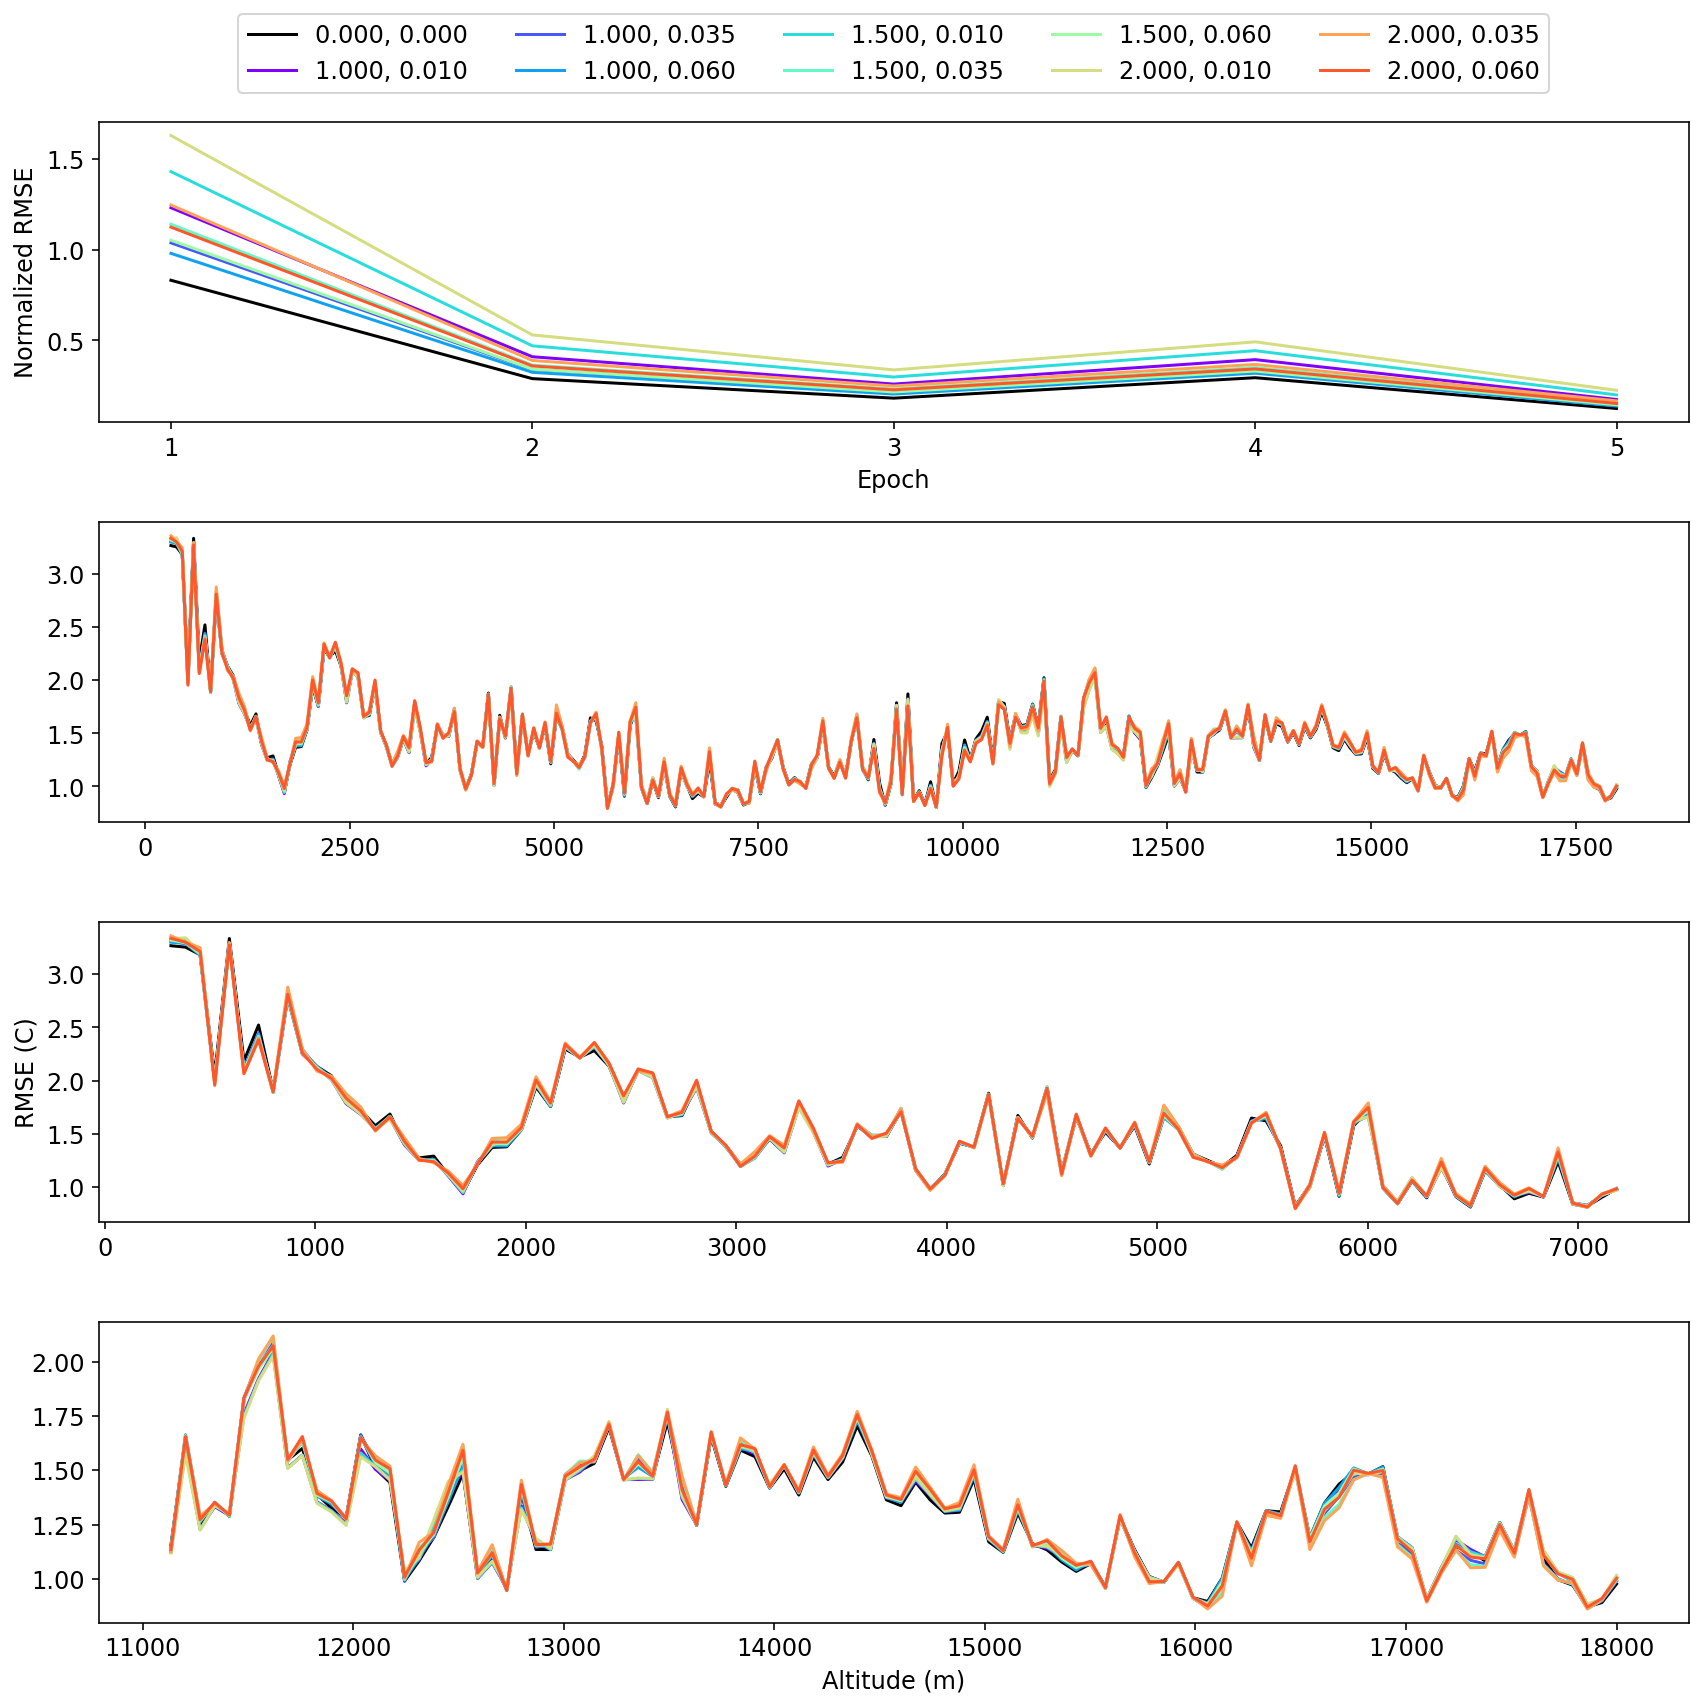

In [290]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
axs = axs.ravel()

color=iter(plt.cm.rainbow(np.linspace(0,1,len(product))))
alt_s = raob[0, :, ALTITUDE][0]
altitude_intervals = np.linspace(alt_s, 18_000, 256)
altitude_window = 100

i = 0
for scale, lmda in product:
    c = next(color) if i > 0 else 'k'
    axs[0].plot(loss_l[i], label=f'{scale:.3f}, {lmda:.3f}', color=c)
    axs[1].plot(altitude_intervals, rmse_l[i], color=c)
    axs[2].plot(altitude_intervals[:altitude_window], rmse_l[i][:altitude_window], color=c)
    axs[3].plot(altitude_intervals[-altitude_window:], rmse_l[i][-altitude_window:], color=c)
    i += 1

axs[0].set_xticks(range(len(loss_l[0])))
axs[0].set_xticklabels(range(1, len(loss_l[0]) + 1))
axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Normalized RMSE')
axs[3].set_xlabel('Altitude (m)'); axs[2].set_ylabel('RMSE (C)');

axs.flatten()[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=5)
fig.tight_layout();

# RAP + GOES

In [8]:
def parition(raob=None, rap=None, goes=None, rtma=None, 
             percentages=(0.8,0.2), shuffle=False):
    
    trainFraction, testFraction = percentages
    n = raob.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    rowIndices = np.arange(n)
    if shuffle:
        np.random.shuffle(rowIndices)
        
    RAPtrain = rap[rowIndices[:nTrain], :] if rap is not None else None
    RAOBtrain = raob[rowIndices[:nTrain], :] if raob is not None else None
    GOEStrain = goes[rowIndices[:nTrain], :] if goes is not None else None
    RTMAtrain = rtma[rowIndices[:nTrain], :] if rtma is not None else None
    
    RAPtest = rap[rowIndices[nTrain:nTrain+nTest], :] if rap is not None else None
    RAOBtest = raob[rowIndices[nTrain:nTrain+nTest], :] if raob is not None else None
    GOEStest = goes[rowIndices[nTrain:nTrain+nTest], :] if goes is not None else None
    RTMAtest = rtma[rowIndices[nTrain:nTrain+nTest], :] if rtma is not None else None
    
    return (RAPtrain, RAOBtrain, GOEStrain, RTMAtrain,
            RAPtest, RAOBtest, GOEStest, RTMAtest)

In [9]:
RAPtrain, RAOBtrain, GOEStrain, _, RAPtest, RAOBtest, GOEStest, _ = parition(raob, rap, goes)

input_dims = [PRESSURE, TEMPERATURE]

RAPtrain = RAPtrain[:, :, input_dims].reshape(RAPtrain.shape[0],-1)
RAOBtrain = RAOBtrain[:, :, TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims].reshape(RAPtest.shape[0],-1)
RAOBtest = RAOBtest[:, :, TEMPERATURE]

RAPtrain.shape, RAOBtrain.shape, GOEStrain.shape, RAPtest.shape, RAOBtest.shape, GOEStest.shape

((114, 512),
 (114, 256),
 (114, 28, 28, 8),
 (28, 512),
 (28, 256),
 (28, 28, 28, 8))

In [80]:
n_goes_inputs = GOEStrain.shape[1:]
n_rap_inputs = RAPtrain.shape[1]
n_outputs = RAOBtrain.shape[1]

tf.keras.backend.clear_session()

X1 = tf.keras.Input(shape=n_goes_inputs, name='goes_in')
Z = X1
Z = tf.keras.layers.Conv1D(10, kernel_size=3, strides=1,
                           activation='relu', padding='same')(Z)
Z = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(Z)
Z = tf.keras.layers.Conv1D(10, kernel_size=3, strides=1,
                           activation='relu', padding='same')(Z)
Z = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(Z)
Z = tf.keras.layers.Dropout(0.20)(Z)

flattned = tf.keras.layers.Flatten()(Z)
X2 = tf.keras.Input(shape=n_rap_inputs, name='rap_in')
Z = tf.keras.layers.concatenate([flattned, X2])

Z = tf.keras.layers.Dense(units=256, activation='tanh')(Z)
Z = tf.keras.layers.Dense(units=128, activation='tanh')(Z)
Z = tf.keras.layers.Dense(units=64, activation='tanh')(Z)
Y = tf.keras.layers.Dense(units=n_outputs, name='out')(Z)

model = tf.keras.Model(inputs=[X1, X2], outputs=Y)

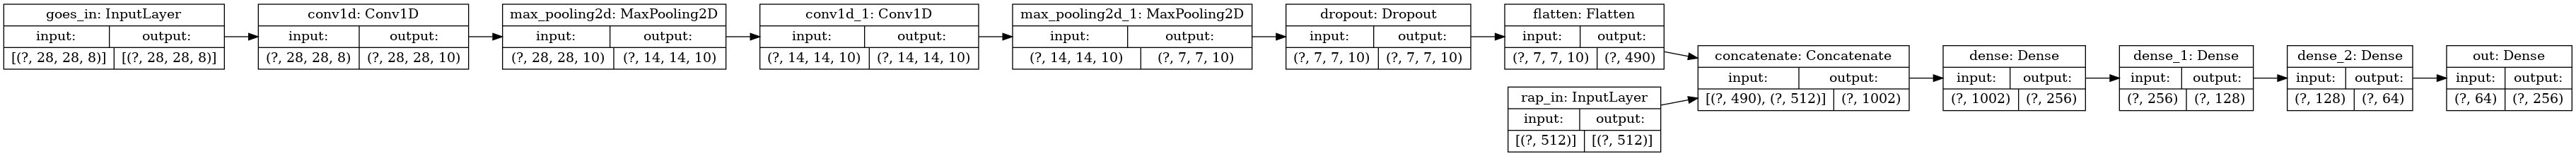

In [81]:
tf.keras.utils.plot_model(model, '/home/stock/research/media/multi_input_and_output_model.png',
                          show_shapes=True, rankdir='LR', dpi=96) # LR/TB positioning

In [82]:
learning_rate = 0.001
n_epochs = 200
batch_size = 16
verbose = None

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss=tf.keras.losses.MSE,
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

callback = [nn.TrainLogger(n_epochs, step=5)] if verbose else None
history = model.fit({'goes_in': GOEStrain, 'rap_in': RAPtrain},
                    {'out': RAOBtrain}, 
                    batch_size=batch_size, epochs=n_epochs,
                    verbose=0, callbacks=callback,
                    validation_data=({'goes_in': GOEStest, 'rap_in': RAPtest},{'out': RAOBtest})).history

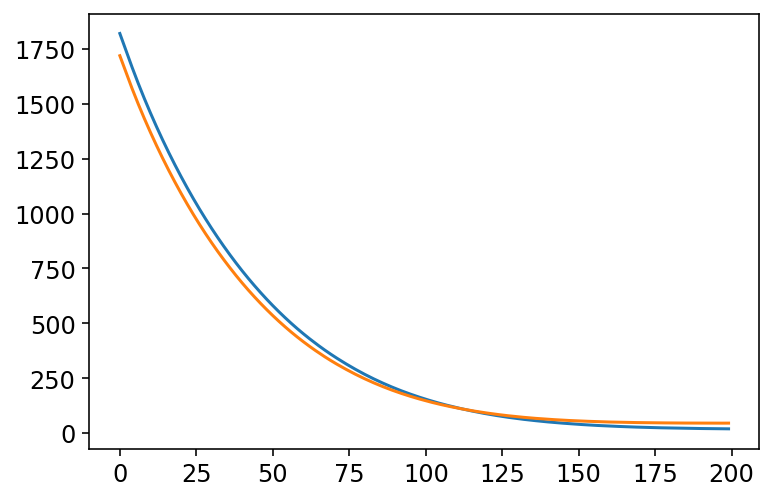

In [83]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

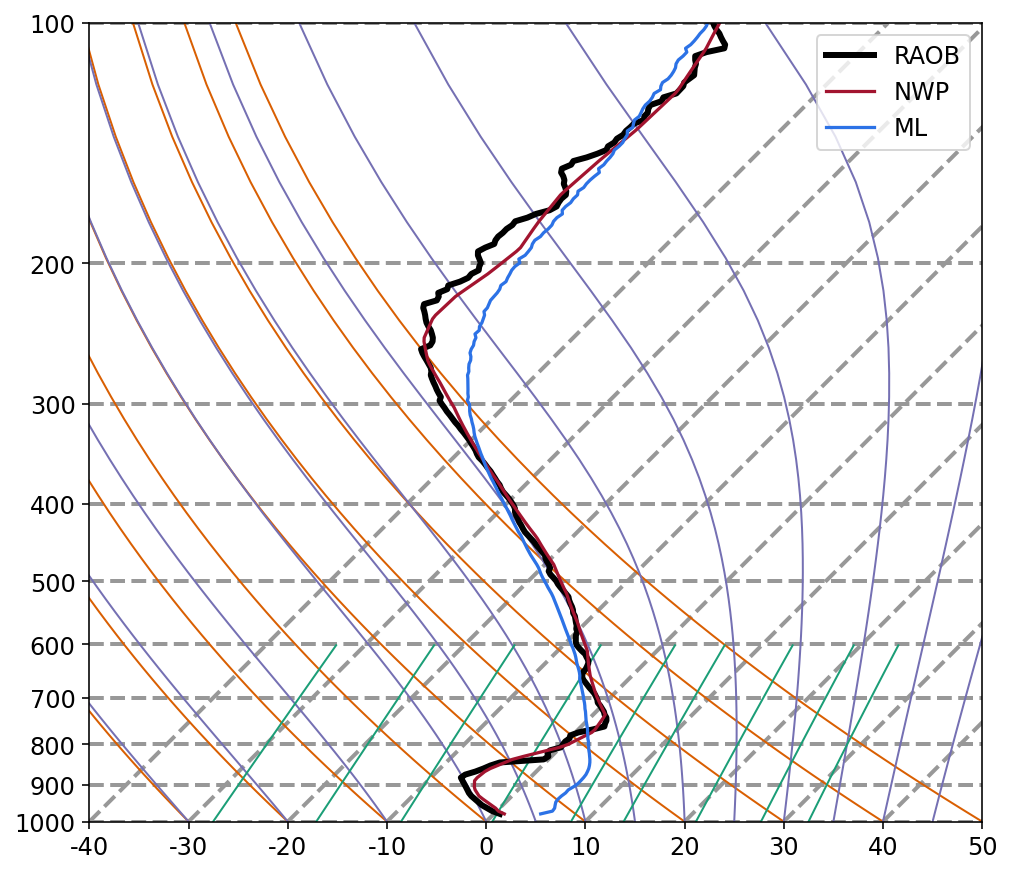

In [84]:
i = 10
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest.reshape(RAPtest.shape[0],
                                                                 RAPtest.shape[1]//len(input_dims),
                                                                 len(input_dims))[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest.reshape(RAPtest.shape[0],
                                                                 RAPtest.shape[1]//len(input_dims),
                                                                 len(input_dims))[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = model.predict({'goes_in': GOEStest[i:i+1],
                                                                             'rap_in': RAPtest[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

# RAP + RTMA

# RAP + GOES + RTMA